<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Miscellaneous/Index_Pairwise_Correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Index Pairwise Correlations
---
### Initialize the Workspace
This is done by bringing in a standard library package, which you can find here [my_library.py](https://github.com/Farmhouse121/Financial-Data-Science-in-Python/blob/main/my_library.py). This needs to be imported into the workspace of the project, and then executed. For brevity, we also turn off `UserWarning` and `FutureWarning`. You can skip that step if you want to.

In [1]:
from my_library import *

15:35:53 Starting...
15:35:53 Installing yfinance into Google notebook...
15:36:05 Installing arch into Google notebook...
15:36:14 Initialized.


In [2]:
# let's ignore some warnings that clutter the output, skip this cell if you want to see them
from warnings import filterwarnings

for warning in UserWarning,FutureWarning:
    filterwarnings("ignore",category=warning)

### Store Results in a DataFrame for Meta-Analysis

In [3]:
try:
    #raise Break # uncomment to reset meta dataframe
    display(meta:=pd.read_pickle("/content/drive/MyDrive/meta.pickle"))
    nprint("Read prior meta-analysis results from Google Drive.")

except:
    meta=pd.DataFrame({("Name","Filter"):[],"N":[],"N*":[],"rho":[]}).set_index(("Name","Filter"))
    nprint("Created empty DataFrame for meta-analysis results.")

,,N,N*,rho,Khat
Name,Filter,,,,
S&P 500,,503.0,6.703451,0.147482,75.035975


15:36:14 Read prior meta-analysis results from Google Drive.


### Load List of Index Members
---
This has been set up to allow you to select one of the known indices by setting that value for `indexname`. In the future, more indices might be added via similar code branches.

In [77]:
nprint("Getting members of %s index." % (indexname:='NASDAQ-100'))

index,first_date=loadindex(indexname)
nprint("Total of %d stocks. First date for data extract is %s." % (index.shape[0],first_date))

17:48:33 Getting members of NASDAQ-100 index.


,Company,GICS Sector,GICS Sub-Industry
Ticker,,,
ADBE,Adobe Inc.,Information Technology,Application Software
AMD,Advanced Micro Devices,Information Technology,Semiconductors
ABNB,Airbnb,Consumer Discretionary,"Hotels, Resorts & Cruise Lines"
GOOGL,Alphabet Inc. (Class A),Communication Services,Interactive Media & Services
GOOG,Alphabet Inc. (Class C),Communication Services,Interactive Media & Services
...,...,...,...
VRTX,Vertex Pharmaceuticals,Health Care,Biotechnology
WBD,Warner Bros. Discovery,Communication Services,Broadcasting
WDAY,"Workday, Inc.",Information Technology,Application Software


17:48:33 Total of 101 stocks. First date for data extract is 2024-01-02.


### Measure Correlations for a Random Sample of Index Member Pairs
---
This analysis is survivorship bias free because data is taken strictly from the last index rebalance only. Fix the random seed to ensure reproducibility.

In [80]:
if 'random_seed' not in locals():
    random_seed=12345678 # don't reset the seed multiple times in one session

if random_seed is not None:
    generator=np.random.default_rng(seed=random_seed)
    nprint("Using NumPy random seed %d." % random_seed)
    random_seed=None

else:
    nprint("Continuing random sequence from prior seed.")

17:49:11 Continuing random sequence from prior seed.


In [82]:
results=pd.DataFrame({"Trial":list(range(N:=5000)),"Ticker 1":[""]*N,"Ticker 2":[""]*N,"Correlation":[np.nan]*N,"Sample":[np.nan]*N}).set_index("Trial")

nprint("Getting daily data for all index stocks, starting on {:s}.".format(first_date))
data=download(list(map(lambda x:x.replace(".","-") if indexname!='FTSE 250' else x,index.index)),first_date).iloc[:-2] # Yahoo! Finance uses - for subclasses of equity

for i in tqdm(results.index):
    df=data["Adj Close"].sample(2,axis=1,random_state=generator)
    df.columns=pd.MultiIndex.from_product([["Adj Close"],df.columns])

    for ticker in (tickers:=list(set(df.columns.get_level_values(1)))):
        df[('Return',ticker)]=df[('Adj Close',ticker)].pct_change()*hundred

    df.dropna(inplace=True)

    if df.shape[0]<10:
        continue

    df.index=pd.DatetimeIndex(df.index).to_period('D')
    results.loc[i,"Ticker 1"]=tickers[0]
    results.loc[i,"Ticker 2"]=tickers[1]
    results.loc[i,"Correlation"]=df["Return"].corr().iloc[0,1]*hundred
    results.loc[i,"Sample"]=df.shape[0]
    results.loc[i,"Fisher"]=np.arctanh(results.loc[i,"Correlation"]/hundred) # Fisher Transform Correlation
    results.loc[i,"Fisher Error"]=np.sqrt(one/(df.shape[0]-three)) # Approx error
    results.loc[i,"Fisher Z Score"]=results.loc[i,"Fisher"]/results.loc[i,"Fisher Error"]

results.dropna(inplace=True)
results=results.loc[~results.index.duplicated()]

if results.shape[0]<10:
    raise RuntimeError("Insufficient data (%d) for analysis to proceed." % results.shape[0])

results.set_index(["Ticker 1","Ticker 2"],inplace=True)
results.loc["Mean","Sample"]=results.shape[0]
results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())
results.loc["Mean","Fisher"]=(f:=results["Fisher"].mean())
results.loc["Mean","Fisher Z Score"]=(f:=results["Fisher Z Score"].mean())
display(results)

17:52:32 Getting daily data for all index stocks, starting on 2024-01-02.


[*********************100%***********************]  101 of 101 completed


  0%|          | 0/5000 [00:00<?, ?it/s]

<ipython-input-82-18357f1b44bf>:34: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Sample"]=results.shape[0]
<ipython-input-82-18357f1b44bf>:35: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())
<ipython-input-82-18357f1b44bf>:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Fisher"]=(f:=results["Fisher"].mean())
<ipython-input-82-18357f1b44bf>:37: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Fisher Z Score"]=(f:=results["Fisher Z Score"].mean())


,,Correlation,Sample,Fisher,Fisher Error,Fisher Z Score
Ticker 1,Ticker 2,,,,,
ORLY,ABNB,5.661683,204.0,0.056677,0.070535,0.803541
INTU,DLTR,6.717673,204.0,0.067278,0.070535,0.953831
DDOG,ABNB,29.795747,204.0,0.307277,0.070535,4.356397
GILD,CDW,10.871808,204.0,0.109149,0.070535,1.547461
MSFT,IDXX,29.028559,204.0,0.298878,0.070535,4.237328
...,...,...,...,...,...,...
ISRG,XEL,-2.310970,204.0,-0.023114,0.070535,-0.327695
BKNG,CSGP,4.664527,204.0,0.046679,0.070535,0.661791
MNST,AMZN,11.824262,204.0,0.118798,0.070535,1.684257


### Make Some Histograms...

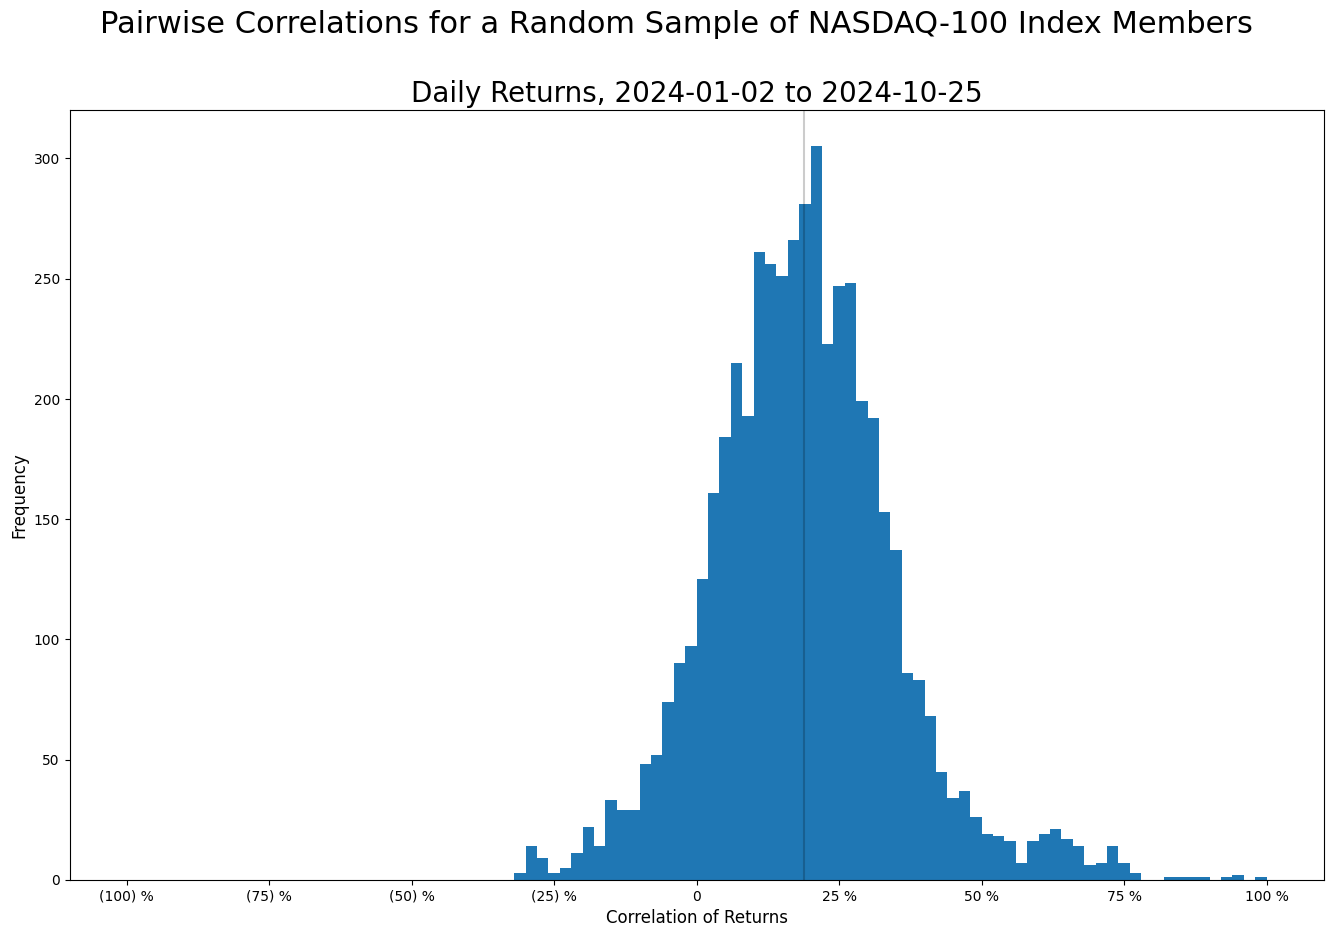

In [85]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
counts,bins,patches=plot.hist(results.loc[results.index!="Mean",'Correlation'].to_numpy(),bins=np.linspace(-hundred,hundred,101))
figure.suptitle(title:="Pairwise Correlations for a Random Sample of %s Index Members" % indexname,fontsize=22)
plot.set_title(subtitle:="Daily Returns, %s to %s" % (first_date,today("%Y-%m-%d")),fontsize=20)
plot.set_xlabel("Correlation of Returns",fontsize=12)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.set_ylabel("Frequency",fontsize=12)
plot.yaxis.set_major_formatter(CountLabels())
plot.axvline(m,color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

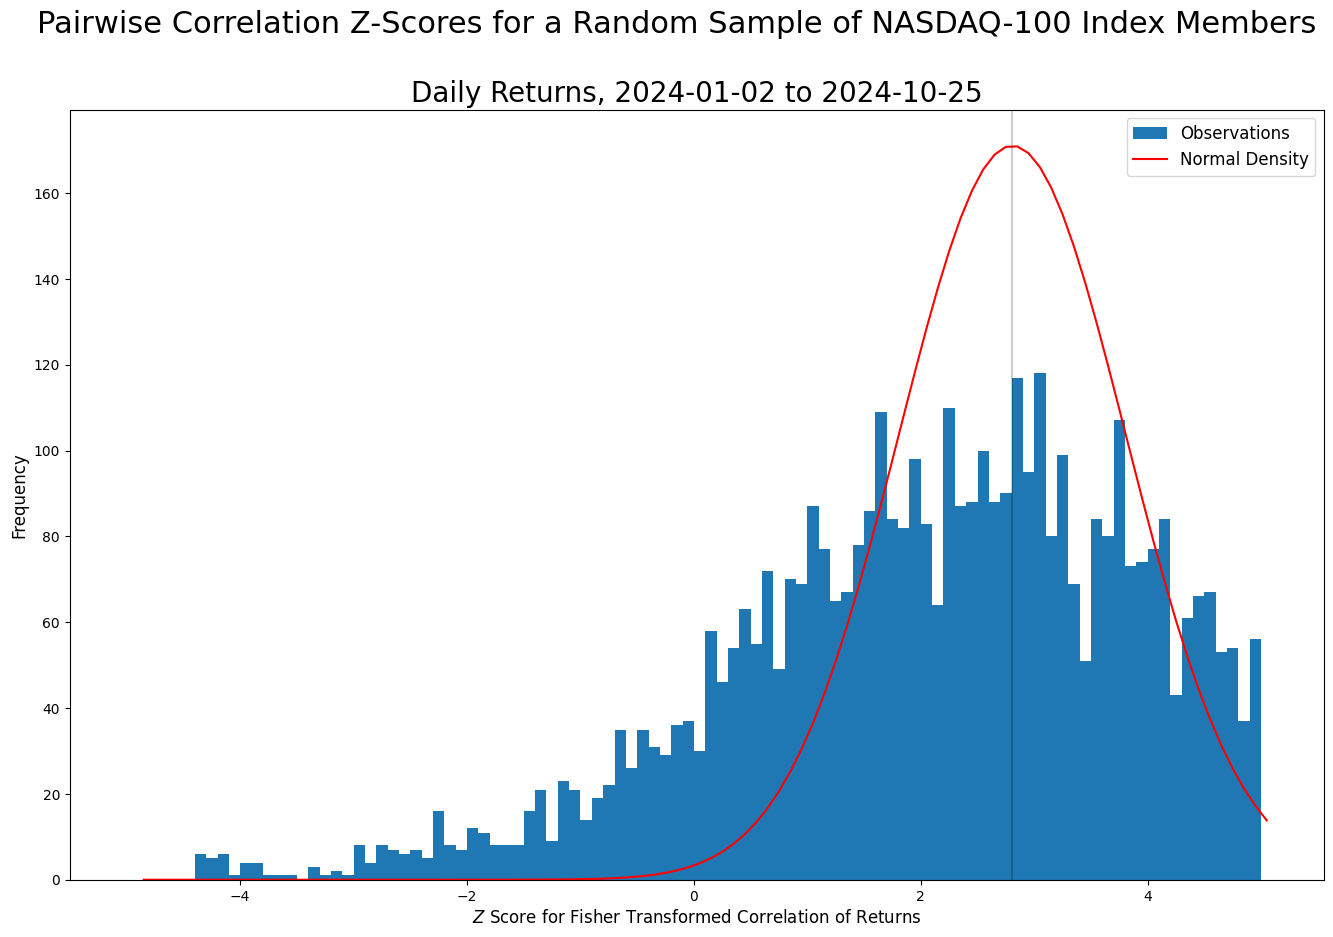

In [84]:
from scipy.stats import norm

Z=results.loc[results.index!="Mean",'Fisher Z Score']
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
counts,bins,patches=plot.hist(Z.to_numpy(),bins=np.linspace(-five,five,101),label='Observations')
plot.plot(x:=bins[1:]+(dx:=bins[1]-bins[0])/two,y:=norm(f,one).pdf(x)*sum(counts)*dx,'-',color='red',label='Normal Density')
figure.suptitle(title:="Pairwise Correlation Z-Scores for a Random Sample of %s Index Members" % indexname,fontsize=22)
plot.set_title(subtitle:="Daily Returns, %s to %s" % (first_date,today("%Y-%m-%d")),fontsize=20)
plot.set_xlabel("$Z$ Score for Fisher Transformed Correlation of Returns",fontsize=12)
plot.set_ylabel("Frequency",fontsize=12)
plot.yaxis.set_major_formatter(CountLabels())
plot.axvline(f,color='black',alpha=0.2)
plot.legend(fontsize=12)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

In [86]:
from scipy.stats import ks_1samp
ks_1samp(Z,norm(f,one).cdf)

KstestResult(statistic=0.20182337160505165, pvalue=4.757514962680425e-179, statistic_location=1.2777459965695193, statistic_sign=1)

### Execute the $N^*$ vs. $N$ Analysis
---
$N^*$ is the effective degrees of freedom found within a portfolio of size $N$. This is computed by comparing the variance of the portfolio returns to the variance we would expect if all the stocks were independent.

In [87]:
results=pd.DataFrame({"Sample":range(1,(n:=1000)+1),"Assets":[np.nan]*n,"Portfolio":[np.nan]*n,"Stocks":[""]*n}).set_index("Sample") # n is number of trials
nprint("Getting daily data for all index stocks, starting on %s." % first_date)
closes=data['Adj Close']
closes.index=pd.DatetimeIndex(closes.index).to_period('B')

nprint("Beginning analysis for {:,d} trials.".format(n))

if (filter:=None) is not None: # choose "Up", "Down" or None
    nprint("Limiting analysis to portfolio %s days only." % filter.lower())
    #returns=closes.pct_change().iloc[1:]*hundred
    #select=returns.mean(axis=1)>zero if filter=='Up' else returns.mean(axis=1)<zero if filter=='Down' else ~returns.mean(axis=1).isna()

for i in tqdm(results.index): # for each trial, pick a random sample of stocks with portfolio sizes uniformly distributed between 1 and maximum, one of 2^503-1 choices
    returns=pd.DataFrame()

    for ticker in closes[generator.choice(closes.columns,generator.integers(1,closes.shape[1]+1),replace=False)]:
        returns[ticker]=closes[ticker].pct_change().dropna()*hundred # compute all adjusted returns, ticker by ticker

        if returns[ticker].shape[0]<1: # exclude time-series that are all NA's
            returns.drop(columns=ticker,inplace=True)

        else:
            returns=returns.copy() # 'cos it frags, apparently

    results.loc[i,"Stocks"]=",".join(returns.columns) # list of stocks in portfolio
    returns.drop(returns.index[-1],inplace=True) # get rid of final print in case unprocessed corporate actions exist
    returns['Portfolio']=returns.mean(axis=1) # equal weighted portfolio return
    select=returns["Portfolio"]>zero if filter=="Up" else returns["Portfolio"]<zero if filter=="Down" else ~returns["Portfolio"].isna()
    results.loc[i,"Assets"]=returns.shape[1]-1 # number of assets we ended up with
    results.loc[i,"Independent"]=returns.loc[select,[a for a in returns if a!="Portfolio"]].var().sum()/results.loc[i,"Assets"]**2 # if no correlation, portfolio variance is total variance divided by square of number of assets
    results.loc[i,"Portfolio"]=returns.loc[select,'Portfolio'].var() # variance of portfolio returns for same period as individual returns

results.dropna(inplace=True)
results["Effective D.o.F."]=results["Independent"]/results["Portfolio"]*results["Assets"]
display(results)
nprint("Done.")

17:56:34 Getting daily data for all index stocks, starting on 2024-01-02.
17:56:34 Beginning analysis for 1,000 trials.


  0%|          | 0/1000 [00:00<?, ?it/s]

,Assets,Portfolio,Stocks,Independent,Effective D.o.F.
Sample,,,,,
1,93.0,0.985929,"MAR,DASH,KHC,CSCO,MDLZ,KLAC,FAST,CDNS,AMGN,SNP...",0.059034,5.568555
2,5.0,1.029518,"PAYX,WBD,MAR,MSFT,BIIB",0.622529,3.023398
3,66.0,0.884833,"MNST,GILD,REGN,IDXX,ON,ARM,MRVL,EA,GEHC,INTC,D...",0.081434,6.074187
4,101.0,0.917029,"DLTR,MNST,WDAY,SMCI,CEG,XEL,MELI,AVGO,FAST,LRC...",0.051804,5.705574
5,3.0,1.950917,"QCOM,CMCSA,META",1.535924,2.361849
...,...,...,...,...,...
996,33.0,0.845012,"WDAY,QCOM,ILMN,AEP,INTC,SMCI,AMZN,NXPI,KDP,INT...",0.161958,6.324902
997,16.0,1.237436,"ODFL,TSLA,DDOG,PAYX,BKNG,WBD,ARM,PCAR,MU,CHTR,...",0.402009,5.197961
998,95.0,0.931587,"AMZN,CTAS,MU,QCOM,AVGO,PYPL,CDW,AEP,AMAT,REGN,...",0.056197,5.730747


17:58:02 Done.


### Fit a Linear Model to $N^*(N)$

In [88]:
from statsmodels.api import OLS,add_constant
design=results[select:=(results["Assets"]>=(Nmin:=50))&(results["Assets"]<=(Nmax:=results["Assets"].max()-one))][[yn:="Effective D.o.F.",xn:="Assets"]].drop_duplicates()
model=OLS(design[yn],add_constant(design[xn])).fit()
nprint(model.summary())
nprint("Implied regression factor count: {:.2f} +/- {:.2g} for data in [{:,.0f},{:,.0f}].".format(Kreg:=one/model.params[1],model.bse[1]/model.params[1]**4,Nmin,Nmax))
final=results[results[xn]==results[xn].max()].drop_duplicates(xn)
Nstar,Nact=tuple(final.iloc[-1][[yn,xn]])
rho=(Nact-Nstar)/((Nact-one)*Nstar)
nprint("{:s} Days: Effective D.o.F. Limit {:,.2f}, Implied Correlation {:.2f} %.".format(filter if filter is not None else "All",Nstar,rho*hundred))
Khat=Nact/Nstar
nprint("Implied limiting factor count: {:.0f}.".format(Khat))
meta=pd.concat([meta,pd.DataFrame({
    "Name":[(indexname,filter if filter is not None else "")],
     "N":[Nact],
    "N*":[Nstar],
    "rho":[rho],
    "Khat":[Khat],
    "Kreg":[Kreg]
}).set_index("Name")])
nprint("Updated Meta-Analysis DataFrame.")

17:58:10                             OLS Regression Results                            
Dep. Variable:       Effective D.o.F.   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     36.53
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           2.91e-09
Time:                        17:58:10   Log-Likelihood:                -174.42
No. Observations:                 511   AIC:                             352.8
Df Residuals:                     509   BIC:                             361.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1575      0.077     67.064

### Make a Plot

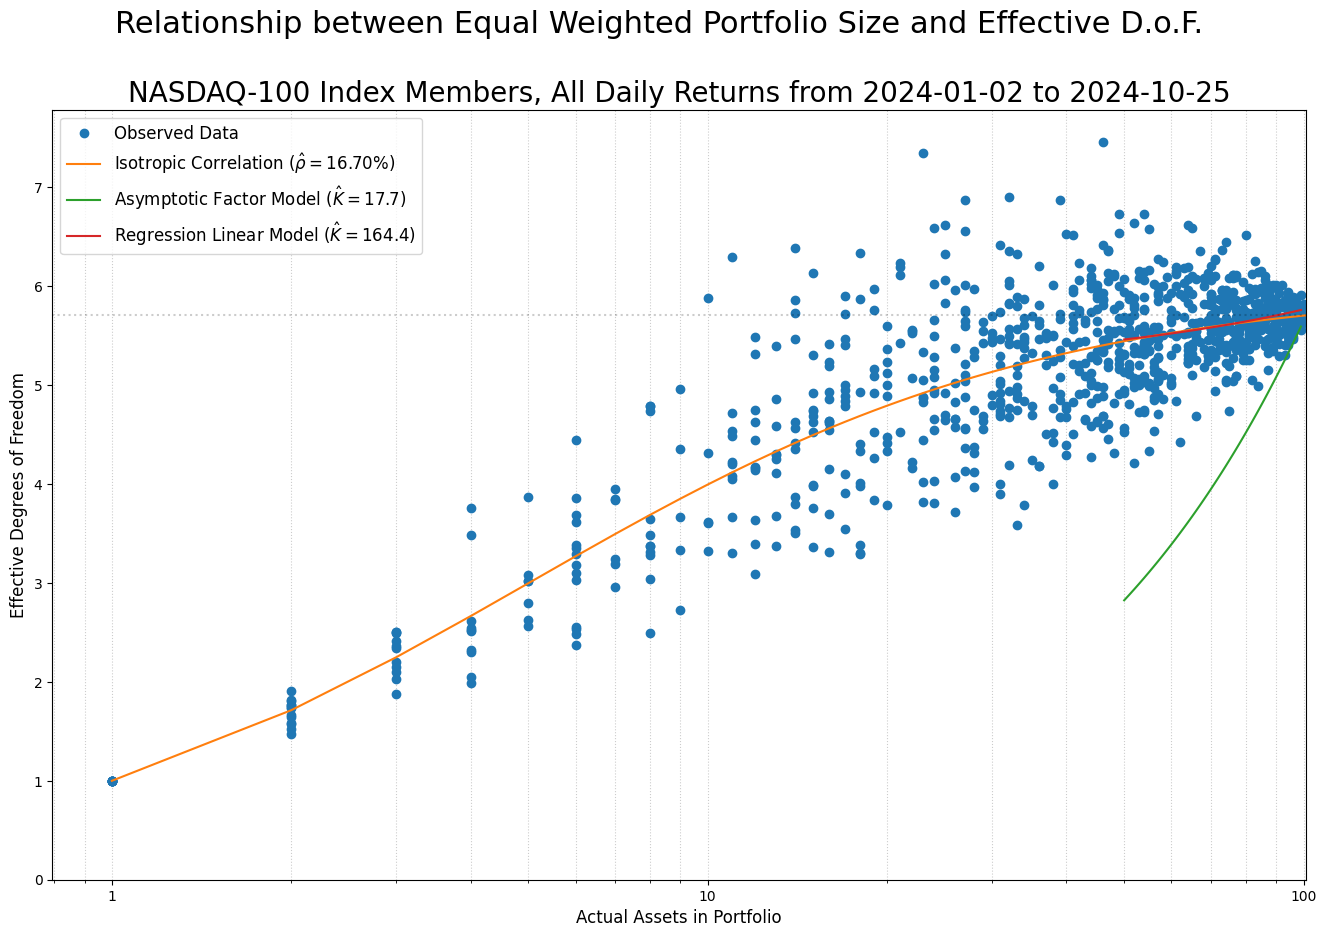

In [89]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=results["Assets"].to_numpy(),y:=results["Effective D.o.F."].to_numpy(),'o',label='Observed Data')
plot.plot(xp:=np.append([] if max(x)>100 else [zero],np.unique(np.sort(x))),xp/(one+(xp-one)*rho),'-',label='Isotropic Correlation ($\\hat{\\rho} = %.2f$%%)' % (rho*hundred))
plot.plot(xpp:=np.arange(Nmin,Nmax,one),xpp/Khat,'-',label="Asymptotic Factor Model ($\\hat{K} = %.1f$)" % Khat)
plot.plot(xpp,model.params[0]+model.params[1]*xpp,'-',label="Regression Linear Model ($\\hat{K} = %.1f$)" % Kreg)
plot.set_xscale('log' if max(x)>100 else 'linear')
plot.set_ylim(zero,None)
plot.set_xlabel("Actual Assets in Portfolio",fontsize=12)
plot.set_ylabel("Effective Degrees of Freedom",fontsize=12)
figure.suptitle(title:="Relationship between Equal Weighted Portfolio Size and Effective D.o.F.",fontsize=22)
plot.set_title("%s Index Members, %s Daily Returns from %s to %s" % (indexname,filter if filter is not None else "All",first_date,pd.Timestamp.today().strftime("%Y-%m-%d")),fontsize=20)
plot.set_xlim(zero,index.shape[0])
plot.legend(fontsize=12)
plot.axhline(Nstar,color='black',linestyle=':',alpha=0.2)
plot.xaxis.set_major_formatter(CountLabels())
plot.grid(which='both',axis='x',linestyle=':',color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### Meta-Analysis
---

In [94]:
meta.index=pd.MultiIndex.from_tuples(meta.index)
meta.index.names=("Name","Filter")
meta=meta.loc[~meta.index.duplicated(keep='last')]

try:
    meta.to_pickle("/content/drive/MyDrive/meta.pickle")
    nprint("Saved meta-analysis results to Google Drive.")

except:
    raise RuntimeError("You need to mount your Google Drive to save results.")

display(meta.sort_values("N",ascending=True))

18:01:47 Saved meta-analysis results to Google Drive.


,,N,N*,rho,Khat,Kreg
Name,Filter,,,,,
NASDAQ-100,,101.0,5.705574,0.167020,17.701988,164.441986
FTSE 250,,249.0,6.801826,0.143580,36.607818,548.401425
S&P 500,,503.0,7.120521,0.138727,70.640900,4758.886351


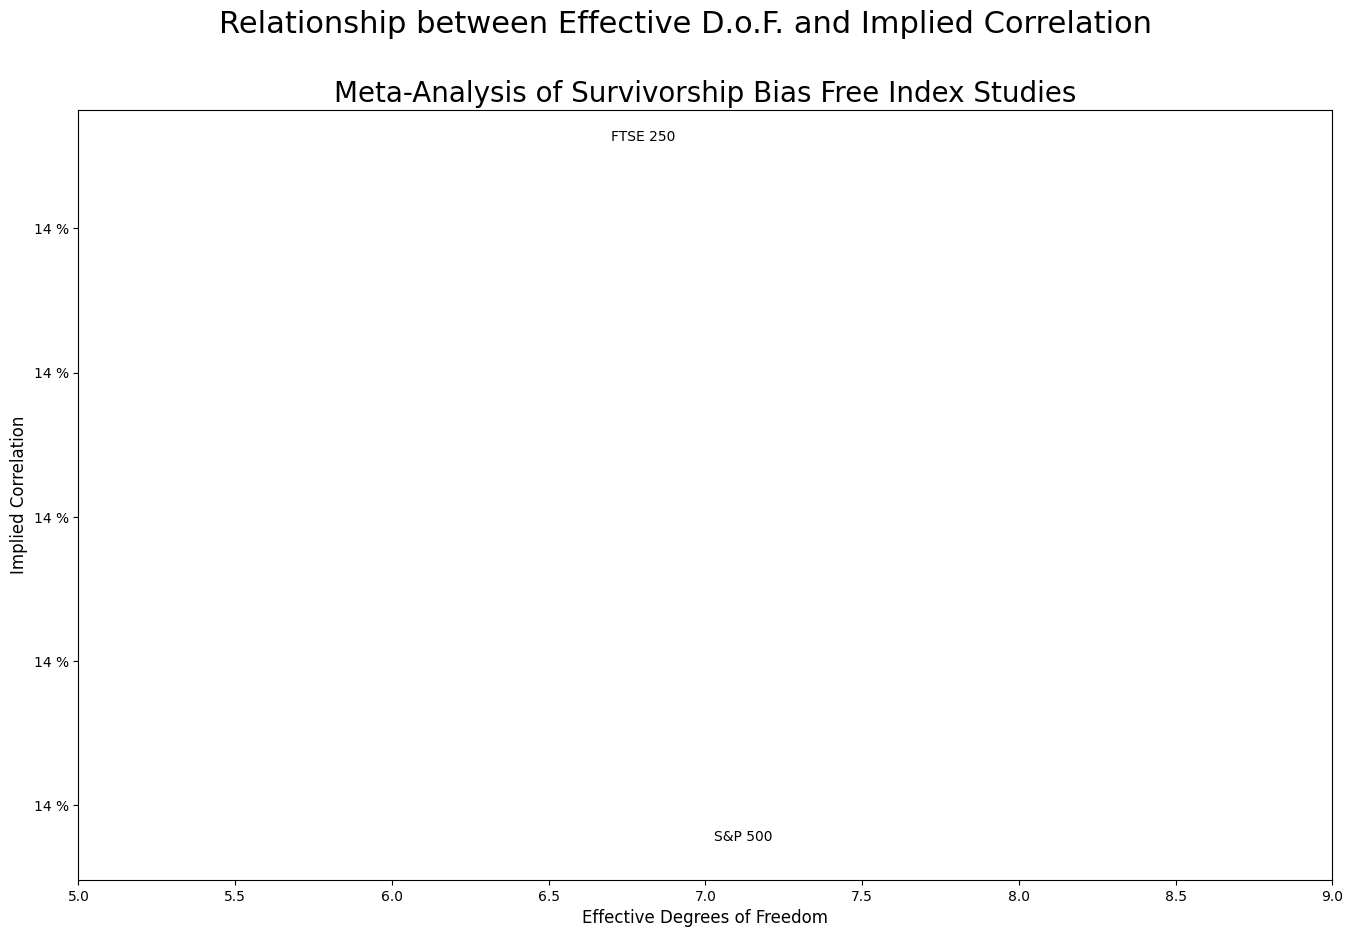

In [72]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=meta["N*"].to_numpy(),y:=meta["rho"].to_numpy()*hundred,'o',label='Observed Data',alpha=zero)
plot.set_xlabel("Effective Degrees of Freedom",fontsize=12)
plot.set_ylabel("Implied Correlation",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(0))
figure.suptitle(title:="Relationship between Effective D.o.F. and Implied Correlation",fontsize=22)
plot.set_title("Meta-Analysis of Survivorship Bias Free Index Studies",fontsize=20)
plot.set_xlim(np.floor(meta["N*"]).min()-one,np.ceil(meta["N*"]).max()+one)

for i in meta.index:
    plot.text(x:=meta.loc[i,"N*"],y:=meta.loc[i,"rho"]*hundred,s:="\n".join(i),ha='center',va='center',fontsize=10)

figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### $\LaTeX$ Code for the Formulae in the Medium Articles
---

$$
V_P=\mathbb{V}\!\left[\frac{1}{N}\sum_{i=1}^Nr_{it}\right]=\frac{1}{N^2}\mathbb{V}\!\left[\sum_{i=1}^Nr_{it}\right]
$$

$$
V_P=\frac{1}{N^2}\sum_{i=1}^N\sigma_i^2+\frac{2}{N^2}\sum_{i=1}^N\sum_{j=i+1}^N\sigma_i\sigma_j\rho_{ij}=V_I+V_C
$$

$$
V_I=\frac{1}{N}\left(\frac{1}{N}\sum_{i=1}^N\sigma_i^2\right)=\frac{\overline{\sigma^2}}{N}
$$

$$
\mathbb{V}[\bar{x}]=\frac{\sigma^2}{N}\;\mathrm{where}\;\mathbb{V}[x_i]=\mathbb{V}[x_j]=\sigma^2\;\mathrm{and}\;\mathbb{C}[x_i,x_j]=0\;\forall\;i,j
$$

$$
V_P=V_I\left(1+\frac{V_C}{V_I}\right)=\frac{\overline{\sigma^2}}{N}\left(1+\frac{V_C}{V_I}\right)
$$

$$
V_P=\frac{\overline{\sigma^2}}{N^*}\;\mathrm{where}\;N^*=N\frac{V_I}{V_P}
$$

$$
\sum_{N=1}^M\begin{pmatrix}M\\ N\end{pmatrix}=2^M-1
$$

$$
2^{503}-1\approx3.3\times10^{150}
$$

$$
\mathbb{V}[r_{it},r_{jt}]=\sigma_{it}\sigma_{jt}\rho\;\Leftrightarrow\;V_t=S_tRS_t\;\mathrm{where}\;R=\begin{pmatrix}
1&\rho&\cdots&\rho\\
\rho&1&\cdots&\rho\\
\vdots&&\ddots&\vdots\\
\rho&\rho&\cdots&1
\end{pmatrix}\;\mathrm{and}\;
S_t=\begin{pmatrix}
\sigma_{1t}&0&\cdots&0\\
0&\sigma_{2t}&\cdots&0\\
\vdots&&\ddots&\vdots\\
0&0&\cdots&\sigma_{Nt}
\end{pmatrix}
$$